In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [3]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
model_version = 'v11.0'

In [5]:
with open('../data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [6]:
df = pd.read_csv(f"../data/processed/spectrometry_photometry.csv")

X = df[spectro_cols + photo_cols + generic_cols]
y = df[target_col]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Activation('relu', name='Act_64')(x)
x = layers.Dropout(0.2, name='Dropout_64')(x)

# Layer 2
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Activation('relu', name='Act_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)

# Layer 3
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.Activation('relu', name='Act_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)

# Layer 4
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Activation('relu', name='Act_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Regression_Model')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Use Huber loss to balance sensitivity to outliers
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.Huber(), 
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 58)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                3776      
                                                                 
 Act_64 (Activation)         (None, 64)                0         
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 Act_128 (Activation)        (None, 128)               0         
                                                                 
 Dropout_128 (Dropout)       (None, 128)          

In [14]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.5,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
2443/2443 [==============================] - 21s 8ms/step - loss: 0.7049 - mae: 0.8409 - mse: 3.6084 - mape: 8.0020 - val_loss: 0.1416 - val_mae: 0.1805 - val_mse: 0.0660 - val_mape: 1.7466
Epoch 2/200
2443/2443 [==============================] - 29s 12ms/step - loss: 0.2976 - mae: 0.5631 - mse: 0.5061 - mape: 5.3370 - val_loss: 0.0482 - val_mae: 0.1353 - val_mse: 0.0409 - val_mape: 1.3110
Epoch 3/200
2443/2443 [==============================] - 36s 15ms/step - loss: 0.2177 - mae: 0.5123 - mse: 0.4201 - mape: 4.8556 - val_loss: 0.0287 - val_mae: 0.1270 - val_mse: 0.0362 - val_mape: 1.2219
Epoch 4/200
2443/2443 [==============================] - 36s 15ms/step - loss: 0.1840 - mae: 0.4754 - mse: 0.3630 - mape: 4.5138 - val_loss: 0.0357 - val_mae: 0.1852 - val_mse: 0.0574 - val_mape: 1.7697
Epoch 5/200
2443/2443 [==============================] - 37s 15ms/step - loss: 0.1635 - mae: 0.4465 - mse: 0.3219 - mape: 4.2451 - val_loss: 0.0288 - val_mae: 0.1189 - val_mse: 0.0453 - val

In [15]:
model.save(f'../models/{model_version}/spec_photo_model.h5')

In [16]:
save_history(history, model_version)

In [17]:
y_pred_full = model.predict(X_test_scaled)

2094/2094 [==============================] - 3s 1ms/step


In [18]:
plot_metrics(y_test, y_pred_full)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0933
Root Mean Squared Error (RMSE): 0.1867
R² Score: 0.9193


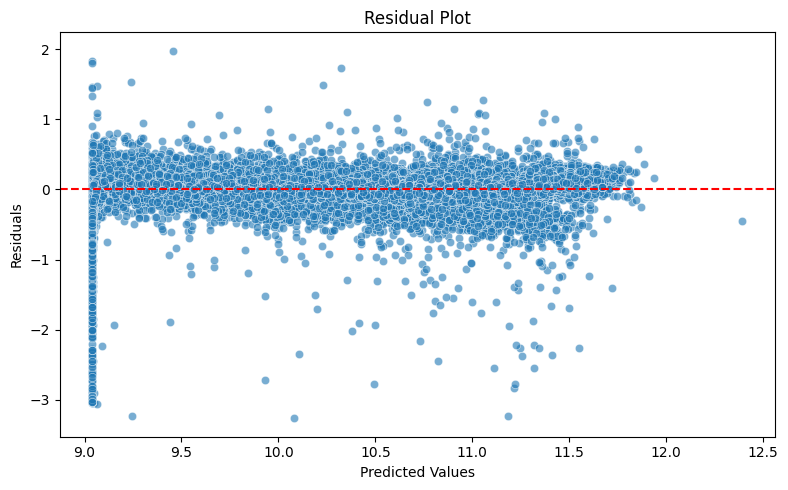

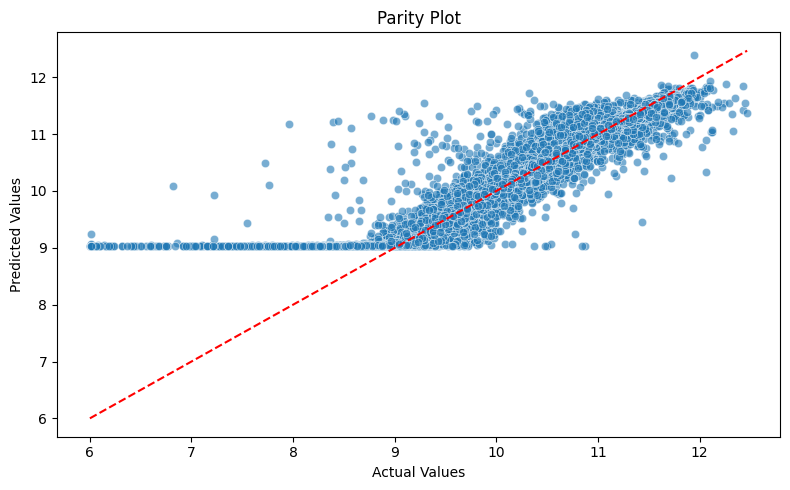

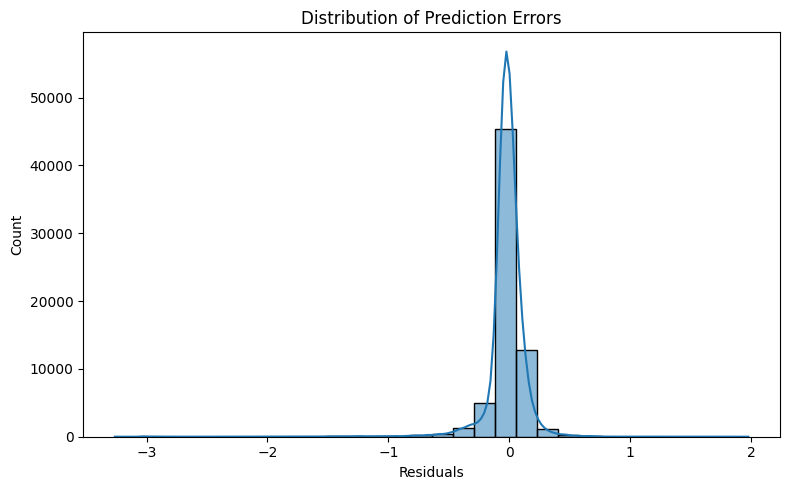

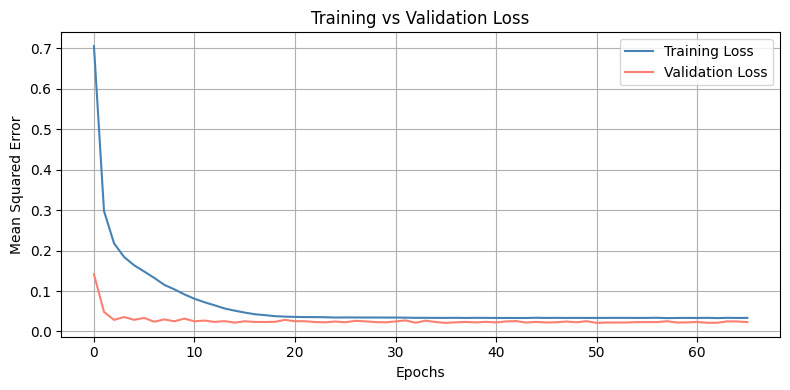

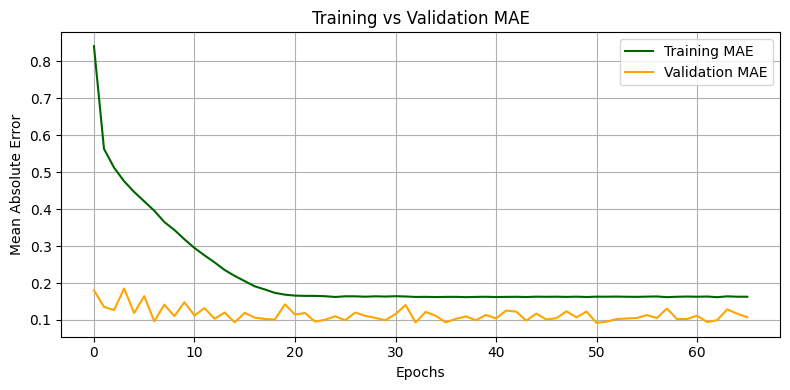

In [19]:
plot_visualizations(history, y_test, y_pred_full)

In [20]:
df_unseen = pd.read_csv(f"../data/processed/unseen_data.csv")

X_unseen = df_unseen[spectro_cols + photo_cols + generic_cols]
y_unseen = df_unseen[target_col]

In [21]:
X_unseen_scaled = scaler.transform(X_unseen)

In [22]:
y_pred_unseen = model.predict(X_unseen_scaled)

6980/6980 [==============================] - 9s 1ms/step


In [23]:
plot_metrics(y_unseen, y_pred_unseen)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0934
Root Mean Squared Error (RMSE): 0.1879
R² Score: 0.9175


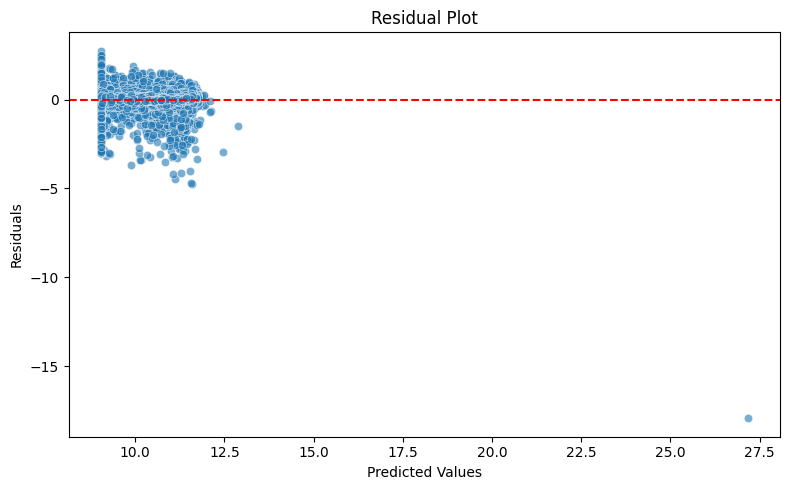

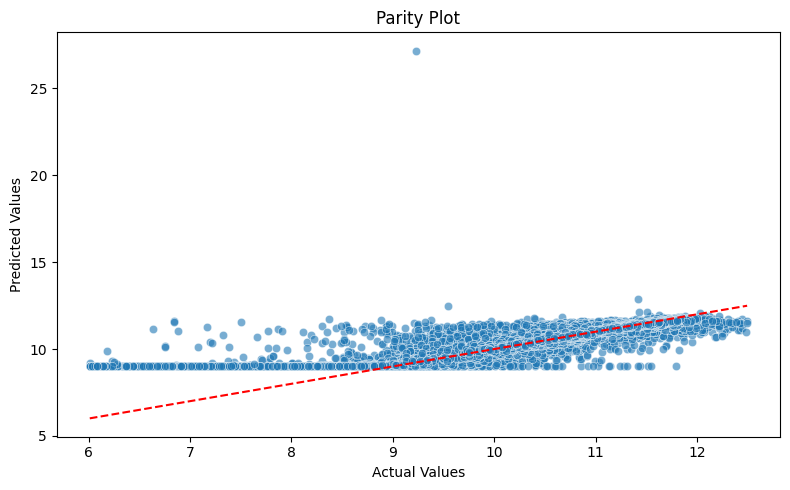

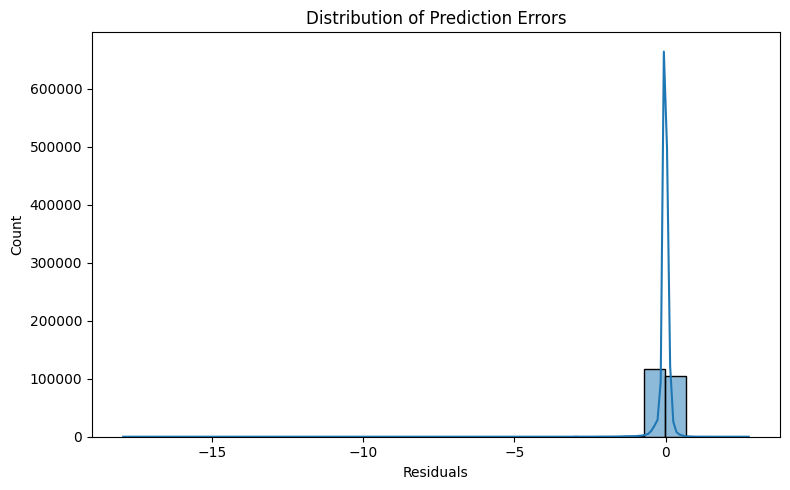

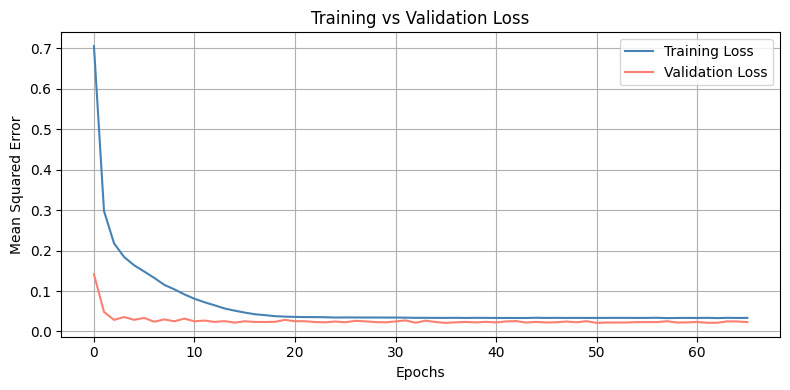

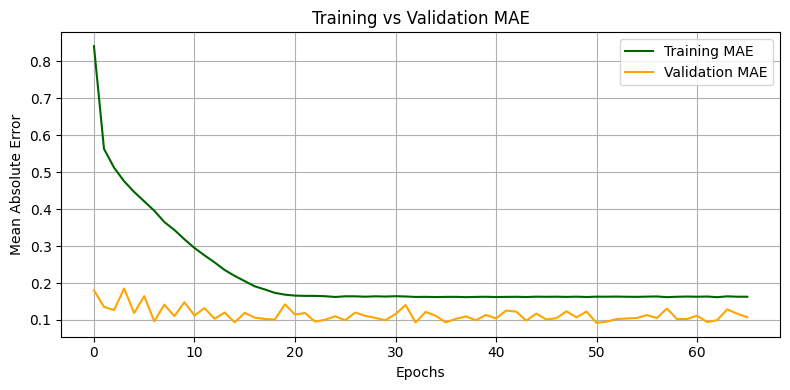

In [24]:
plot_visualizations(history, y_unseen, y_pred_unseen)